**Keras MNIST PQT/QAT Tutorial**

Load tensorflow library

In [2]:
import os
import tensorflow as tf
print(tf.__version__)

!pip install tensorflow_model_optimization

2.13.0
2.13.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Lab/Practice4/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load dataset (MNIST)

In [4]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()


Preprocessing dataset

In [5]:
import numpy as np
input_shape = (32, 32, 3)

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_train = x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], *input_shape)
x_test = x_test / 255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)


Define and train the baseline model

In [ ]:
batch_size = 64
epochs = 50


reg = tf.keras.regularizers.l2(1e-4)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', input_shape=input_shape, kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(16, 3, padding='same', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=reg)
])

schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=x_train.shape[0] * epochs // batch_size)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=schedule, weight_decay=0),
            loss='categorical_crossentropy', metrics=['acc'])


from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )

#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = len(x_train) / batch_size, epochs=epochs, validation_data=(x_test, y_test))

In [ ]:
tf.keras.models.save_model(model, os.path.join(base_path, "model.h5"))
model.save_weights(os.path.join(base_path, "model.weight"))

<ipython-input-12-110d44319415>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, os.path.join(base_path, "model.h5"))


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Save the model.
with open(os.path.join(base_path, 'model.tflite'), 'wb') as f:
  f.write(tflite_model)

## 실험1. 블록별 quant 진행과 파레토 차트

In [6]:
!pip install wandb

In [10]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


실험을 진행하기 위한 셋팅

In [9]:
# 첫번째 블락부터, 세번째 블락까지 순서대로 quantize 실험을 진행하여 W&B에 기록
config = {'batch_size' : 64,
          'epochs' : 5,
           'lr' : 0.001,
           'optimizer' : 'adam'}


In [7]:
import wandb

In [10]:
wandb.init(project='quanize_first', entity='dntjd527', config=config)

wandb: Currently logged in as: dntjd527. Use `wandb login --relogin` to force relogin


In [21]:
config = wandb.config

In [11]:
import wandb.keras

callbacks = [wandb.keras.WandbCallback()]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [12]:
wandb.finish()

Apply Quantization-aware Training

In [ ]:
from tensorflow_model_optimization.quantization.keras import quantize_apply
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer


reg = tf.keras.regularizers.l2(1e-4)

model = tf.keras.models.Sequential([
    quantize_annotate_layer(tf.keras.layers.Conv2D(16, 3, padding='same', input_shape=input_shape, kernel_regularizer=reg)),
    quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
    quantize_annotate_layer(tf.keras.layers.ReLU()),
    quantize_annotate_layer(tf.keras.layers.Conv2D(16, 3, padding='same', kernel_regularizer=reg)),
    quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
    quantize_annotate_layer(tf.keras.layers.ReLU()),
    quantize_annotate_layer(tf.keras.layers.MaxPooling2D()),

    quantize_annotate_layer(tf.keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=reg)),
    quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
    quantize_annotate_layer(tf.keras.layers.ReLU()),
    quantize_annotate_layer(tf.keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=reg)),
    quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
    quantize_annotate_layer(tf.keras.layers.ReLU()),
    quantize_annotate_layer(tf.keras.layers.MaxPooling2D()),

    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=reg)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=reg)
])

model.load_weights(os.path.join(base_path, "model.weight"))

schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = config.lr, decay_steps=x_train.shape[0] * config.epochs // config.batch_size)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )


# quantize_apply: 8bit linear quantization for both weight & Activation
# No quantization threshold just min max so maybe large quantization error

quantized_model = quantize_apply(model)
quantized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=schedule, weight_decay=0),
            loss='categorical_crossentropy', metrics=['acc'])


quantized_model.fit(datagen.flow(x_train, y_train, batch_size=config.batch_size),
                    steps_per_epoch = len(x_train) / config.batch_size, epochs=config.epochs, validation_data=(x_test, y_test),
                    callbacks = callbacks)

wandb.finish()


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model) # path to the SavedModel directory

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open(os.path.join(base_path, 'firstlayer_quant.tflite'), 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
print("Float model in Kb:", os.path.getsize(os.path.join(base_path, "model.tflite")) / float(2**10))
print("Quantized model in Kb:",  os.path.getsize(os.path.join(base_path, "firstlayer_quant.tflite")) / float(2**10))


Float model in Kb: 290.39453125
Quantized model in Kb: 284.421875


모델 사이즈 vs 정확도 파레토 차트

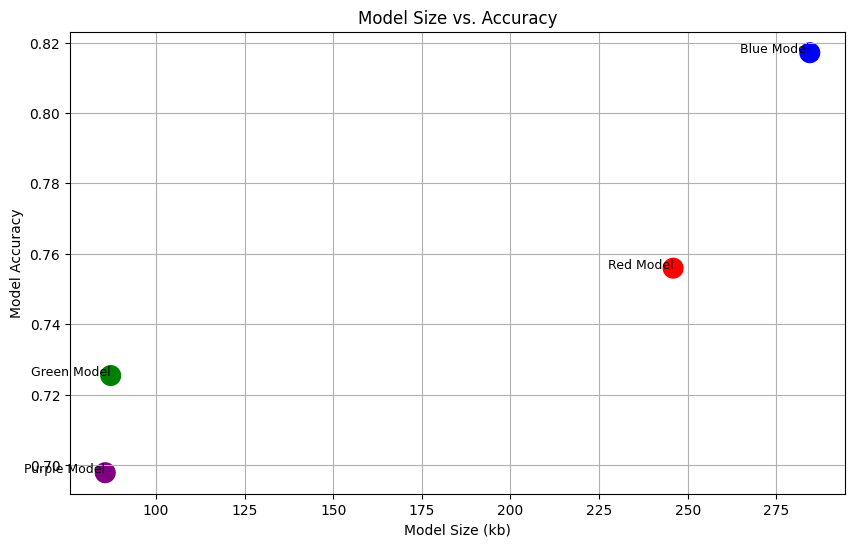

In [32]:
import matplotlib.pyplot as plt

# Data
models = ["Blue Model", "Red Model", "Green Model", "Purple Model"]
sizes = [284.421875, 245.8828125, 87.2578125, 85.7265625]
accuracies = [0.8171, 0.7559, 0.7254, 0.6978]

# Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(sizes, accuracies, s=200, c=['blue', 'red', 'green', 'purple'])  # s parameter controls the size of circles
for i, txt in enumerate(models):
    plt.annotate(txt, (sizes[i], accuracies[i]), fontsize=9, ha='right')

plt.title('Model Size vs. Accuracy')
plt.xlabel('Model Size (kb)')
plt.ylabel('Model Accuracy')
plt.grid(True)
plt.show()




## 실험2. 하이퍼파라미터 최적화

### Sweep_config 설정하기

In [22]:
sweep_config = {'method' : 'grid',
                'metric' : {'name' : 'loss',
                            'goal' : 'minimize'},
                'name' : 'Lab4_Experiment2(Fine Tuning)'}

In [23]:
parameters_dict = {'batch_size' : {'values' : [32,64,128]},
                   'epochs' : {'values' : [5,10]},
                   'lr' : {'values' : [0.001, 0.005]}}

In [24]:
sweep_config['parameters'] = parameters_dict

### sweep id 초기화

In [ ]:
!pip install wandb
!wandb login

In [25]:
sweep_id = wandb.sweep(sweep_config,project = 'Lab4-2',entity = 'dntjd527')

Create sweep with ID: tv7swiq7
Sweep URL: https://wandb.ai/dntjd527/Lab4-2/sweeps/tv7swiq7


In [26]:
from tensorflow_model_optimization.quantization.keras import quantize_apply
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer


def run_sweep(config = None):
    wandb.init(config = config)
    reg = tf.keras.regularizers.l2(1e-4)
    config = wandb.config

    model = tf.keras.models.Sequential([
        quantize_annotate_layer(tf.keras.layers.Conv2D(16, 3, padding='same', input_shape=input_shape, kernel_regularizer=reg)),
        quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
        quantize_annotate_layer(tf.keras.layers.ReLU()),
        quantize_annotate_layer(tf.keras.layers.Conv2D(16, 3, padding='same', kernel_regularizer=reg)),
        quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
        quantize_annotate_layer(tf.keras.layers.ReLU()),
        quantize_annotate_layer(tf.keras.layers.MaxPooling2D()),

        quantize_annotate_layer(tf.keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=reg)),
        quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
        quantize_annotate_layer(tf.keras.layers.ReLU()),
        quantize_annotate_layer(tf.keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=reg)),
        quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
        quantize_annotate_layer(tf.keras.layers.ReLU()),
        quantize_annotate_layer(tf.keras.layers.MaxPooling2D()),

        quantize_annotate_layer(tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=reg)),
        quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
        quantize_annotate_layer(tf.keras.layers.ReLU()),
        quantize_annotate_layer(tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=reg)),
        quantize_annotate_layer(tf.keras.layers.BatchNormalization()),
        quantize_annotate_layer(tf.keras.layers.ReLU()),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=reg)
    ])

    model.load_weights(os.path.join(base_path, "model.weight"))

    schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate = config.lr, decay_steps=x_train.shape[0] * config.epochs // config.batch_size)



    from keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=15,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1
        #zoom_range=0.3
        )


# quantize_apply: 8bit linear quantization for both weight & Activation
# No quantization threshold just min max so maybe large quantization error

    quantized_model = quantize_apply(model)
    quantized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=schedule, weight_decay=0),
                loss='categorical_crossentropy', metrics=['acc'])


    quantized_model.fit(datagen.flow(x_train, y_train, batch_size=config.batch_size),
                        steps_per_epoch = len(x_train) / config.batch_size, epochs=config.epochs, validation_data=(x_test, y_test),
                        callbacks = callbacks)

    wandb.finish()

In [27]:
wandb.agent(sweep_id, function= run_sweep, count = 12)

wandb: Agent Starting Run: ydlzu9ee with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 0.001


Epoch 1/5
1563/1562 [==============================] - ETA: 0s - loss: 1.3976 - acc: 0.5051

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 89s 51ms/step - loss: 1.3976 - acc: 0.5051 - val_loss: 1.3006 - val_acc: 0.5614
Epoch 2/5
1562/1562 [============================>.] - ETA: 0s - loss: 1.0772 - acc: 0.6319

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 78s 50ms/step - loss: 1.0773 - acc: 0.6320 - val_loss: 1.1482 - val_acc: 0.6149
Epoch 3/5
1563/1562 [==============================] - ETA: 0s - loss: 0.9268 - acc: 0.6910

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 77s 49ms/step - loss: 0.9268 - acc: 0.6910 - val_loss: 0.9757 - val_acc: 0.6808
Epoch 4/5
1562/1562 [============================>.] - ETA: 0s - loss: 0.8387 - acc: 0.7222

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 75s 48ms/step - loss: 0.8385 - acc: 0.7223 - val_loss: 0.8370 - val_acc: 0.7233
Epoch 5/5
1562/1562 [============================>.] - ETA: 0s - loss: 0.7976 - acc: 0.7393

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 78s 50ms/step - loss: 0.7975 - acc: 0.7393 - val_loss: 0.8080 - val_acc: 0.7349


acc,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▄▃▁▁
val_acc,▁▃▆██
val_loss,█▆▃▁▁
acc,0.73932
best_epoch,4
best_val_loss,0.808
epoch,4
loss,0.79755
val_acc,0.7349


wandb: Agent Starting Run: mzvlxv2r with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 0.005


Epoch 1/5
1562/1562 [==============================] - 78s 45ms/step - loss: 1.4664 - acc: 0.4929 - val_loss: 1.4598 - val_acc: 0.5134
Epoch 2/5
1562/1562 [==============================] - 69s 44ms/step - loss: 1.1334 - acc: 0.6453 - val_loss: 1.1141 - val_acc: 0.6624
Epoch 3/5
1562/1562 [==============================] - 64s 41ms/step - loss: 0.9866 - acc: 0.7020 - val_loss: 1.0066 - val_acc: 0.7020
Epoch 4/5
1563/1562 [==============================] - ETA: 0s - loss: 0.8618 - acc: 0.7456

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 78s 50ms/step - loss: 0.8618 - acc: 0.7456 - val_loss: 0.8042 - val_acc: 0.7671
Epoch 5/5
1563/1562 [==============================] - ETA: 0s - loss: 0.7789 - acc: 0.7732

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 76s 49ms/step - loss: 0.7789 - acc: 0.7732 - val_loss: 0.7795 - val_acc: 0.7722


acc,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_acc,▁▅▆██
val_loss,█▄▃▁▁
acc,0.77316
best_epoch,4
best_val_loss,0.77945
epoch,4
loss,0.77894
val_acc,0.7722


wandb: Agent Starting Run: s761pk2s with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	lr: 0.001


Epoch 1/10
1562/1562 [==============================] - 78s 45ms/step - loss: 1.3620 - acc: 0.5214 - val_loss: 1.8940 - val_acc: 0.4692
Epoch 2/10
1562/1562 [==============================] - 70s 45ms/step - loss: 1.0655 - acc: 0.6355 - val_loss: 1.5216 - val_acc: 0.5194
Epoch 3/10
1562/1562 [==============================] - 70s 45ms/step - loss: 0.9505 - acc: 0.6826 - val_loss: 1.1185 - val_acc: 0.6388
Epoch 4/10
1562/1562 [==============================] - 70s 45ms/step - loss: 0.8751 - acc: 0.7105 - val_loss: 1.0301 - val_acc: 0.6679
Epoch 5/10
1562/1562 [==============================] - 70s 45ms/step - loss: 0.8185 - acc: 0.7325 - val_loss: 0.9626 - val_acc: 0.6872
Epoch 6/10
1562/1562 [==============================] - 73s 46ms/step - loss: 0.7759 - acc: 0.7499 - val_loss: 0.8511 - val_acc: 0.7337
Epoch 7/10
1562/1562 [==============================] - 70s 44ms/step - loss: 0.7327 - acc: 0.7644 - val_loss: 0.8279 - val_acc: 0.7404
Epoch 8/10
1563/1562 [==========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 77s 50ms/step - loss: 0.7057 - acc: 0.7736 - val_loss: 0.7153 - val_acc: 0.7751
Epoch 9/10
1563/1562 [==============================] - ETA: 0s - loss: 0.6863 - acc: 0.7815

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231018_134542-6bmo9u3a/files/model-best)... Done. 0.0s


1562/1562 [==============================] - 78s 50ms/step - loss: 0.6863 - acc: 0.7815 - val_loss: 0.6781 - val_acc: 0.7861
Epoch 10/10
1562/1562 [==============================] - 74s 47ms/step - loss: 0.6779 - acc: 0.7831 - val_loss: 0.6884 - val_acc: 0.7835


acc,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▂▅▅▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
acc,0.78314
best_epoch,8
best_val_loss,0.67806
epoch,9
loss,0.6779
val_acc,0.7835


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l67zori1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	lr: 0.005


Epoch 1/10
1562/1562 [==============================] - 79s 45ms/step - loss: 1.4604 - acc: 0.4948 - val_loss: 2.0588 - val_acc: 0.4727
Epoch 2/10
1562/1562 [==============================] - 70s 45ms/step - loss: 1.1852 - acc: 0.6232 - val_loss: 1.8079 - val_acc: 0.5148
Epoch 3/10
1562/1562 [==============================] - 67s 43ms/step - loss: 1.0842 - acc: 0.6750 - val_loss: 1.4824 - val_acc: 0.5907
Epoch 4/10
1562/1562 [==============================] - 67s 43ms/step - loss: 1.0093 - acc: 0.7084 - val_loss: 1.1259 - val_acc: 0.6676
Epoch 5/10
1562/1562 [==============================] - 70s 45ms/step - loss: 0.9383 - acc: 0.7316 - val_loss: 0.9929 - val_acc: 0.7174
Epoch 6/10
1562/1562 [==============================] - 71s 45ms/step - loss: 0.8677 - acc: 0.7544 - val_loss: 0.8288 - val_acc: 0.7672
Epoch 7/10
1562/1562 [==============================] - 71s 45ms/step - loss: 0.7983 - acc: 0.7734 - val_loss: 0.8524 - val_acc: 0.7631
Epoch 8/10
1562/1562 [==========================

acc,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▂▃▅▆▇▇███
val_loss,█▇▅▃▃▂▂▁▁▁
acc,0.81348
epoch,9
loss,0.6715
val_acc,0.8086
val_loss,0.68635


wandb: Agent Starting Run: ohub6pk5 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	lr: 0.001


Epoch 1/5


781/781 [==============================] - 66s 71ms/step - loss: 1.3861 - acc: 0.5089 - val_loss: 2.0131 - val_acc: 0.3946
Epoch 2/5
781/781 [==============================] - 55s 70ms/step - loss: 1.0726 - acc: 0.6308 - val_loss: 1.0789 - val_acc: 0.6224
Epoch 3/5
781/781 [==============================] - 59s 75ms/step - loss: 0.9396 - acc: 0.6843 - val_loss: 0.9543 - val_acc: 0.6789
Epoch 4/5
781/781 [==============================] - 56s 72ms/step - loss: 0.8622 - acc: 0.7106 - val_loss: 0.8771 - val_acc: 0.7091
Epoch 5/5
781/781 [==============================] - 57s 73ms/step - loss: 0.8212 - acc: 0.7253 - val_loss: 0.8504 - val_acc: 0.7214


acc,▁▅▇██
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_acc,▁▆▇██
val_loss,█▂▂▁▁
acc,0.72534
epoch,4
loss,0.82116
val_acc,0.7214
val_loss,0.85044


wandb: Agent Starting Run: os5cfe66 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	lr: 0.005


Epoch 1/5
781/781 [==============================] - 63s 72ms/step - loss: 1.3998 - acc: 0.5138 - val_loss: 1.7677 - val_acc: 0.4647
Epoch 2/5
781/781 [==============================] - 56s 71ms/step - loss: 1.0794 - acc: 0.6468 - val_loss: 1.2132 - val_acc: 0.6179
Epoch 3/5
781/781 [==============================] - 56s 72ms/step - loss: 0.9378 - acc: 0.7035 - val_loss: 1.0689 - val_acc: 0.6786
Epoch 4/5
781/781 [==============================] - 53s 67ms/step - loss: 0.8214 - acc: 0.7470 - val_loss: 0.8239 - val_acc: 0.7492
Epoch 5/5
781/781 [==============================] - 50s 64ms/step - loss: 0.7519 - acc: 0.7704 - val_loss: 0.7662 - val_acc: 0.7724


acc,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_acc,▁▄▆▇█
val_loss,█▄▃▁▁
acc,0.77044
epoch,4
loss,0.75188
val_acc,0.7724
val_loss,0.7662


wandb: Agent Starting Run: 9qvo2lml with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.001


Epoch 1/10
781/781 [==============================] - 61s 70ms/step - loss: 1.3864 - acc: 0.5064 - val_loss: 1.9874 - val_acc: 0.3863
Epoch 2/10
781/781 [==============================] - 56s 71ms/step - loss: 1.0939 - acc: 0.6246 - val_loss: 1.2243 - val_acc: 0.6055
Epoch 3/10
781/781 [==============================] - 53s 68ms/step - loss: 0.9711 - acc: 0.6730 - val_loss: 1.1672 - val_acc: 0.6160
Epoch 4/10
781/781 [==============================] - 56s 71ms/step - loss: 0.8910 - acc: 0.7027 - val_loss: 1.0761 - val_acc: 0.6334
Epoch 5/10
781/781 [==============================] - 54s 69ms/step - loss: 0.8292 - acc: 0.7245 - val_loss: 0.8246 - val_acc: 0.7247
Epoch 6/10
781/781 [==============================] - 55s 70ms/step - loss: 0.7844 - acc: 0.7422 - val_loss: 0.8789 - val_acc: 0.7151
Epoch 7/10
781/781 [==============================] - 54s 69ms/step - loss: 0.7459 - acc: 0.7543 - val_loss: 0.7543 - val_acc: 0.7522
Epoch 8/10
781/781 [==============================] - 53s 68ms

acc,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▅▅▆▇▇████
val_loss,█▄▃▃▂▂▁▁▁▁
acc,0.7792
epoch,9
loss,0.68806
val_acc,0.7651
val_loss,0.72696


wandb: Agent Starting Run: 61ztawl4 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.005
wandb: Ctrl + C detected. Stopping sweep.
